# P8 - GP Extra: Regresión para toda la serie histórica

# Nombre: Daniel Herce Cruz

# NIP:  848884

In [60]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (
    RBF,
    ConstantKernel,
    ExpSineSquared,
    RationalQuadratic,
    WhiteKernel,
)

%matplotlib inline

## a) Leer datos de uno de los indicadores en la estación centro

Hay disponibles 5 indicadores: `O3`, `N2`, `CO` y `NOx`. Algunas observaciones:


1. Cada indicador tiene medidas solo en algunos días. Esto significa que tendréis que <br> 
ajustar el rango de predicción en función del indicador que elijais.

2. Algunos indicadores tienen huecos en la serie temporal, por lo que se puede predecir <br> 
en los huecos. También podéis crear los huecos vosotros eliminando datos.

3. Observar los datos y proponer kernels para ajustar la serie temporal. 
<!-- <br> Recordad que una suma se puede interpretar como un OR y una multiplicación como un AND. Podéis ver un ejemplo para CO2 [aqui](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_co2.html). -->

4. Podéis subsamplear los datos. Revisar la complejidad que tiene el GP a nivel computacional.

Variables y funciones auxiliares para facilitar el flujo de trabajo <br>
(Sentiros libres de modificarlas y añadir más si lo consideráis necesario).

In [61]:
files_id_mapper = {
    "o3": "O3ZgzCentro.csv",
    "n2": "N2ZgzCentro.csv",
    "co": "COZgzCentro.csv",
    "nox": "noxZgzCentro.csv",
}


def load_data(contaminante="o3"):
    file = files_id_mapper[contaminante]
    df = pd.read_csv(file, sep=",")
    df = df[["fecha", "value"]]

    # transforma la fecha a un valor numérico (días desde 2000-01-01):
    referencia = pd.Timestamp("2000-01-01")
    df["fecha"] = pd.to_datetime(df["fecha"], dayfirst=True, errors="raise")
    df["fecha"] = (df["fecha"] - referencia).dt.days
    df.sort_values("fecha", inplace=True)

    # dataset a ajustar por Gaussian Process:
    X, y = df["fecha"].values[:, None], df["value"].values[:, None]
    return X, y


def plot_gp2(X, m, std_pred, training_points=None):
    """Plotting utility to plot a GP fit with 95% confidence interval"""
    fig, ax = plt.subplots()
    ax.plot(X, m, label="Mean prediction")
    ax.fill_between(
        X.ravel(),
        m - 1.96 * std_pred,
        m + 1.96 * std_pred,
        alpha=0.5,
        label=r"95% confidence interval",
    )

    if training_points is not None:
        X_, Y_ = training_points
        ax.plot(X_, Y_, "kx", mew=2)
        ax.legend(labels=["GP fit", "sample points"])

    ax.set(xlabel="$x$", ylabel="$f(x)$", title="Gaussian process regression")
    ax.legend()
    fig.tight_layout()

Tamaño de X: (794, 1)
Tamaño de y: (794, 1)


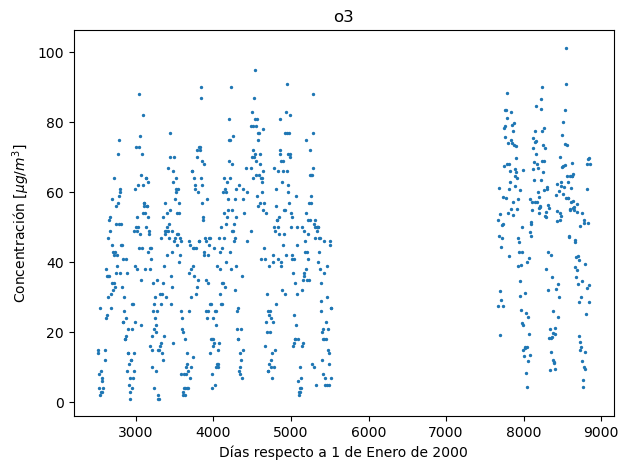

In [68]:
contaminante = "o3"
X, y = load_data(contaminante)


# set the step to subsample the dataset
subsample = 5
X = X[::subsample]
y = y[::subsample]

# Make sure the data is there
print(f"Tamaño de X: {X.shape}")
print(f"Tamaño de y: {y.shape}")



# visualización de los datos
fig, ax = plt.subplots()
ax.scatter(X.ravel(), y.ravel(), s=2)
ax.set(
    xlabel="Días respecto a 1 de Enero de 2000",
    ylabel=r"Concentración [$\mu g/m^3$]",
    title=contaminante,
)
fig.tight_layout()



## b) Diseño del kernel y proceso Gaussiano

Observa los datos, propón un kernel y ajusta los parámetros a mano.

Kernel: ExpSineSquared(length_scale=1, periodicity=365) * RationalQuadratic(alpha=0.01, length_scale=10) + WhiteKernel(noise_level=0.2)
Log-marginal-likelihood: -760.742


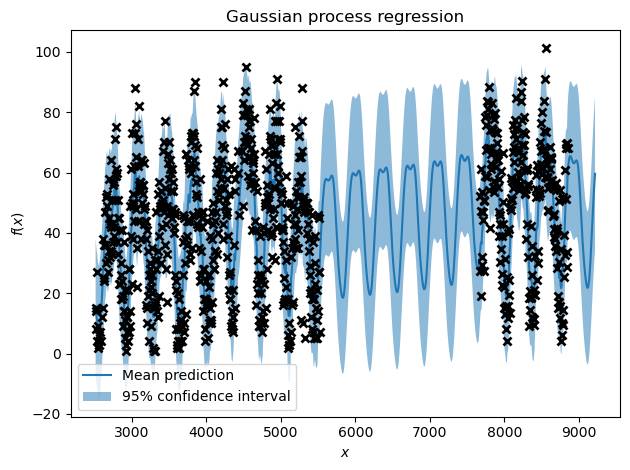

In [74]:
gprNoOp = GaussianProcessRegressor(
    kernel= ExpSineSquared(length_scale=1, periodicity=365) * RationalQuadratic(alpha=0.01, length_scale=10) + WhiteKernel(noise_level=0.2),
    normalize_y=True,
    alpha=0.1,
    optimizer=None,
    # n_restarts_optimizer=10,
)

gprNoOp.fit(X, y)
print(f"Kernel: {gprNoOp.kernel_}")
print(f"Log-marginal-likelihood: {gprNoOp.log_marginal_likelihood(gprNoOp.kernel_.theta):.3f}")


X_pred = np.linspace(X.min(), X.max() + 365, 1000)[:, None]
y_pred, std_pred = gprNoOp.predict(X_pred, return_std=True)

plot_gp2(X_pred, y_pred, std_pred, training_points=(X, y))


Los datos se ve que claramente son periódicos, ya que tiene sentido que la contaminación sea mayor según la época del año en la que se está.
Esta es la razón de haber añadido un kernel periódico con periodicidad anual.
RationalQuadratic es un kernel que se ajusta bien a la serie temporal, ya que es una combinación de kernels de largo y corto alcance.
El kernel sumado de ambos añadiendo un kernel de ruido hacen una buena aproximación a la serie temporal.

## c) Optimiza el Kernel (sus hipérparámetros)

Kernel: ExpSineSquared(length_scale=1.72, periodicity=365) * RationalQuadratic(alpha=0.0116, length_scale=6.36) + WhiteKernel(noise_level=0.187)
Log-marginal-likelihood: -756.304


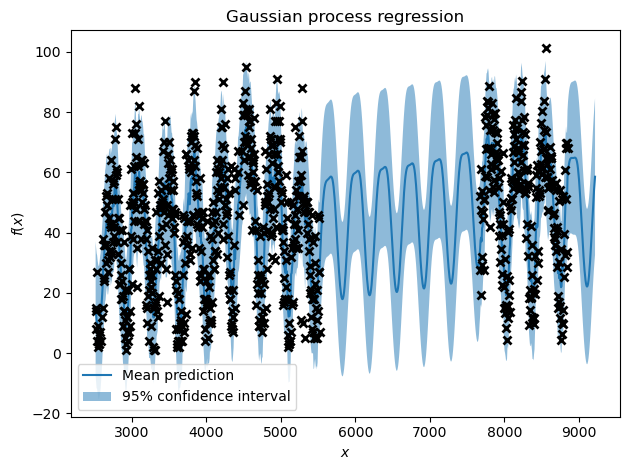

In [75]:
gprOp = GaussianProcessRegressor(
    kernel= ExpSineSquared(length_scale=2, periodicity=365) * RationalQuadratic(alpha=0.01, length_scale=100) + WhiteKernel(noise_level=0.5),
    normalize_y=True,
    alpha=0.1,
    n_restarts_optimizer=10,
)

gprOp.fit(X, y)
print(f"Kernel: {gprOp.kernel_}")
print(f"Log-marginal-likelihood: {gprOp.log_marginal_likelihood(gprOp.kernel_.theta):.3f}")


X_pred = np.linspace(X.min(), X.max() + 365, 1000)[:, None]
y_pred, std_pred = gprOp.predict(X_pred, return_std=True)

plot_gp2(X_pred, y_pred, std_pred, training_points=(X, y))

Kernel: ExpSineSquared(length_scale=2, periodicity=365) * DotProduct(sigma_0=100) + WhiteKernel(noise_level=1)
Log-marginal-likelihood: -1038.366


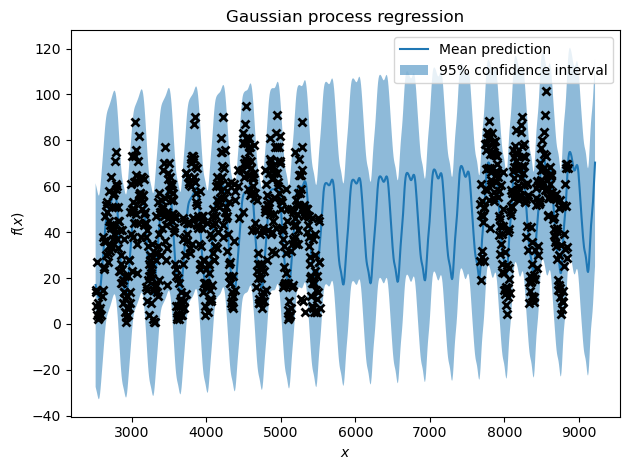

In [59]:
from sklearn.gaussian_process.kernels import DotProduct
gprOp = GaussianProcessRegressor(
    kernel= ExpSineSquared(length_scale=2, periodicity=365) * DotProduct(sigma_0=100) + WhiteKernel(noise_level=1),
    normalize_y=True,
    alpha=0.1,
    optimizer=None,
    n_restarts_optimizer=10,
)

gprOp.fit(X, y)
print(f"Kernel: {gprOp.kernel_}")
print(f"Log-marginal-likelihood: {gprOp.log_marginal_likelihood(gprOp.kernel_.theta):.3f}")


X_pred = np.linspace(X.min(), X.max() + 365, 1000)[:, None]
y_pred, std_pred = gprOp.predict(X_pred, return_std=True)

plot_gp2(X_pred, y_pred, std_pred, training_points=(X, y))

Escribe aquí tus conclusiones. Recuerda que es mejor tener gráficas y datos de las pruebas que hayas hecho para la justificación.


La periodicidad de 365 días es la que mejor se ajusta a la serie temporal, ya que es un año. Y RationalQuadratic es el que mejor se ajusta a la serie temporal, ya que es una combinación de kernels de largo y corto alcance, es decir, combina 